<div style="text-align: right">Ioannis Karakasoglou Breier </div> 
# OpenStreetMap Project - Data Wrangling with SQL
---

### Table of Contents

* [Project Overwiew](#Project-Overwiew)
* [Map Area](#Map-Area)
* [Problems Encountered in the Map](#Problems-Encountered-in-the-Map)  
    * [Inconsistent or overlapping building types](#Inconsistent-or-overlapping-building-types)     
    * [Inconsistent phone numbers](#Inconsistent-phone-numbers)
    * [Inconsistent Cafe Names](#Inconsistent-Cafe-Names)
* [Data Overview](#Data-Overview)
* [Additional Ideas](#Additional-Ideas)
* [References](#References)


## Project Overwiew
---
[OpenStreetMap](https://www.openstreetmap.org)(OSM) is a free, editable map of the whole world that is being built by volunteers largely from scratch and released with an open-content license.  
The [OpenStreetMap License](https://www.openstreetmap.org/copyright) allows free (or almost free) access to our map images and all of our underlying map data. The project aims to promote new and interesting uses of this data.

The data is stored in XML format and is generated by different users and therefore prone to many errors.

In this Project, I choose a map of Warsaw from the OSM and use data munging techniques to:

* Audit map data for validity, accuracy, completeness,consistency and uniformity.
* Fix the problems encountered and export the audited data from XML to CSV format .
* Store the CSV's into an sqlite database (using the selected schema) and use SQL to query and aggregate the stored data.


## Map Area
---
<img src="Metro-Extracts_Warsaw.png" alt="Metro-Extracts_Warsaw" style="width: 400px;"/>

[Warsaw, Poland](https://mapzen.com/data/metro-extracts/metro/warsaw_poland/)

This map is from the town I probably spend most of my time over the last years.  I’m quite interested to see what database querying reveals, and I’d like an opportunity to contribute to its improvement on OpenStreetMap.org.

It is the suggested Metro Extract and the overall filesize of the unzipped xml file is ~1.2 Gb.

## Problems Encountered in the Map
---
After initially downloading a smaller sample size of the Warsaw I started
the wrangling process by investigating the various elements.


I did not find  any problems with street abreviations as it often happens, because only the name of the street is used.
In cases of square the description `plac` is correctly used.

The problems encountered, and I will discuss are the following:

* Inconsistent or overlapping building types ('boat', 'boathouse','houseboat' or 'civ','civic')

* Inconsistent phone numbers(+ 48 22 620, 00482263210, 22 31 82 80 )

* Inconsistent and Inaccurate Cafe Names (Costa Coffee,  Costa Coffee, Green Caffè Nero,  Green Caffe Nero etc).

### Inconsistent or overlapping building types

Looking into the `key:building` I noticed that there are many custom entries that do not appear at the wiky for this 'key' and have only one entry in Warsaw map
as well as in the entire OSM Database.

Auditing, for uniformity and consistency I choose to follow the logic described at
the [Key:building - wiki page](http://wiki.openstreetmap.org/wiki/Key:building#Possible_Tagging_Mistakes) and 
use the json provided by the [API](https://taginfo.openstreetmap.org/taginfo/apidoc#api_4_key_values) with the
most common values to filter the values of my map based on their number of occurences or the existence
of a wiki entry.

The number of `building` values that did not have a wiki entry and had less than 5 occurences in the OSM db where 59.

I audited the majority of them using the function `correct_building()` from the file audit.py, attempting to match general patterns observed in the map, in the following fashion: 

```Python
def correct_building(val):

    if val in building_mapping.keys():
        return building_mapping[val]
    else:

        if  'shop' in val or 'store' in val or 'retail' in val or 'food' in val:
            building_mapping[val] = 'retail'
        elif 'office' in val or 'commercial' in val:
            building_mapping[val] = 'commercial'
        elif 'residential' in val:
            building_mapping[val] = 'apartments'
        elif 'muse' in val:
            building_mapping[val] = 'museum'
        elif 'ruin' in val or 'collapsed' in val:
            building_mapping[val] = 'ruins'```
            
            ...            
```Python    
        else:
            building_mapping[val]=val
            
        return building_mapping[val]```
        
The function uses a global dictionary that it updates for every value it is called.
        
The following keys:
```Python
'belfry','cage','corridor','empty','enclosing','military','no',,'part','passage','prison','tent','terminal',
'tower', 'tribunes', 'iy'```    
where not mapped since I could not find an adequate category for these without being in danger of deleting precious information.

After standardizing the key:building running the below SQL query we get 89 distinct entries for the building key.

The top 10 values sorted by the count we get for the building key are the following:

In [53]:
#DON'T RUN
SELECT tags.value, COUNT(*) as count 
FROM (SELECT * FROM nodes_tags 
      UNION ALL 
      SELECT * FROM ways_tags) as tags
WHERE tags.key='building'
GROUP BY tags.value
ORDER BY count DESC
LIMIT 10;

value                           count     
------------------------------  ----------
yes                             277144    
apartments                      18019     
house                           16474     
terrace                         1681      
garage                          1610      
commercial                      1592      
industrial                      952       
farm_auxiliary                  930       
garages                         830       
retail                          819       


And the 10 last ones:

In [54]:
#DON'T RUN
SELECT tags.value, COUNT(*) as count 
FROM (SELECT * FROM nodes_tags 
      UNION ALL 
      SELECT * FROM ways_tags) as tags
WHERE tags.key='building'
GROUP BY tags.value
ORDER BY count 
LIMIT 10;

value                           count     
------------------------------  ----------
Basen                           1         
Budynek Zabytkowy               1         
Lokal                           1         
National_Monument               1         
Plutonowego Józefa Ciećwierz  1         
bunker                          1         
cage                            1         
cathedral                       1         
civ                             1         
day_care                        1         


Still there remains the problem of handling the values that have only one entry and ruin the consistency.

### Inconsistent phone numbers

Looking into the phone number 'key', the entries where quite messy and Inconsistent.

According to the [Key:phone - wiki](http://wiki.openstreetmap.org/wiki/Key:phone)
the phone numbers should one of have the following two formats:

- `phone=+<country code> <area code> <local number>`, following the ITU-T E.123 and the DIN 5008 pattern
- `phone=+<country code>-<area code>-<local number>`, following the RFC 3966/NANP pattern

I chose the first one ,and again , auditing for consistence, uniformity and accuracy, used the relative functions in audit.py to transform them programatically to the desired format taking into consideration the possibility that foreign numbers may exist.
Multible numbers where transformed to single numbers and extra characters and letters where deleted in the following fashion: 

```
Mapped: +48 225827500 => +48 22 5827500
Mapped: 662 350 728 => +48 66 2350728
Mapped: +48 22 833 56 60 => +48 22 8335660
Mapped: +48 22 822 27 50 => +48 22 8222750
Mapped: 22 870 03 07;22 870 03 76;517 129 105 => +48 22 8700307
Mapped: 226213280 => +48 22 6213280
Mapped: +48226416331 => +48 22 6416331
...
Mapped: Telefon:795 975 644 => +48 79 5975644
...
```       

### Inconsistent Cafe Names

After storing the data in database and querying for the Cafe chains I noticed there are quite a few overlapping and inconsistent values and looked like this:

In [52]:
#DON'T RUN
SELECT a.value, COUNT(*) as num
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as a
      JOIN
     (SELECT DISTINCT(id) FROM nodes_tags WHERE nodes_tags.value='cafe'
      AND nodes_tags.id NOT IN
                       (SELECT ways_nodes.node_id FROM ways_nodes
                        JOIN
                       (SELECT DISTINCT(id) FROM ways_tags WHERE ways_tags.value='cafe') as b
                       ON ways_nodes.id = b.id)
      UNION ALL
      SELECT DISTINCT(id) FROM ways_tags WHERE ways_tags.value='cafe') as c
      ON a.id=c.id
WHERE a.key='name'
GROUP BY a.value
ORDER BY num DESC
LIMIT 10;

value                           num       
------------------------------  ----------
Costa Coffee                    26        
Green Caffè Nero               11        
Starbucks                       11        
Costa                           9         
Grycan                          5         
Green Coffee                    4         
Rue de Paris                    4         
A. Blikle                       3         
Cukiernia Sowa                  3         
Green Cafe Nero                 3         


 I used the function `correct_cafe_names()` to audit and correct the cafe names in a fashion similar to the `correct_building()` function I described above with the difference that I used a boolean switch to identify the elements that had the value `cafe` in their tag attributes.

## Data Overview
---

This section contains basic statistics, some  further exploration of the dataset and the SQL queries used to gather them  and aggregate the data.

### File sizes
After running data.py and importing the resulting CSV's into a SQLite Database the following files where created:

```Bash
warsaw_poland.osm...............1.2Gb 

warsaw_poland_nodes.csv.........383Mb
warsaw_poland_nodes_tags.csv.....87Mb
warsaw_poland_ways.csv...........37Mb
warsaw_poland_ways_nodes.csv....136Mb
warsaw_poland_ways_tags.csv......66Mb

warsaw_Poland.db................655Mb```

I will use the [ipython-sql](https://github.com/catherinedevlin/ipython-sql) module to connect to the database and get my results into padas.

First , connect to the Database.

In [10]:
%load_ext sql

%sql sqlite:///warsaw_poland.db   

And set some parameters

In [14]:
%config SqlMagic.feedback = False

### Number of Nodes

In [38]:
%sql SELECT COUNT(*) as Number_of_Nodes FROM nodes

Number_of_Nodes
4916335


### Number of Ways

In [39]:
%sql SELECT COUNT(*) as Number_of_Ways FROM ways

Number_of_Ways
633304


### Number of unique users

In [41]:
%%sql
SELECT COUNT(DISTINCT(sq.uid)) as 'Number of unique users'           
FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) as sq;

Number of unique users
2928


### Top 10 contributing users

In [80]:
%%sql 
SELECT sq.user, COUNT(*) as num
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) as sq
GROUP BY sq.user
ORDER BY num DESC
LIMIT 10;

user,num
rosomak,1574106
kocio,400130
Zibi-importy,204599
Madmaks,148603
Alkomat,130533
WiktorN-import,125867
lasica1982,122545
Andrzej3345,120256
balrog-kun-imports,119231
RuteX,108396


### Number of total entries

In [44]:
%%sql
SELECT SUM(num) as tot_num
FROM
(SELECT COUNT(*) as num
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) as sq
GROUP BY sq.user)

tot_num
5549639


### Number of users appearing only once (having 1 post)

In [25]:
SELECT COUNT(*)
FROM
    (SELECT sq.user, COUNT(*) as num 
    FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) as sq
GROUP BY sq.user
HAVING num=1);

668                           


Top user `rosomak` has 28.36% of the total entries in the map and the top three users represent 39% of the total entries.
The top 10 contributing users represent 55% of the total entries.

We will import the results in Pandas and visualize them

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-ticks')

In [56]:
#capture all conributing users
result = %sql  SELECT sq.user, COUNT(*) as num FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) as sq GROUP BY sq.user ORDER BY num DESC

#get them in a dataframe
df = result.DataFrame()

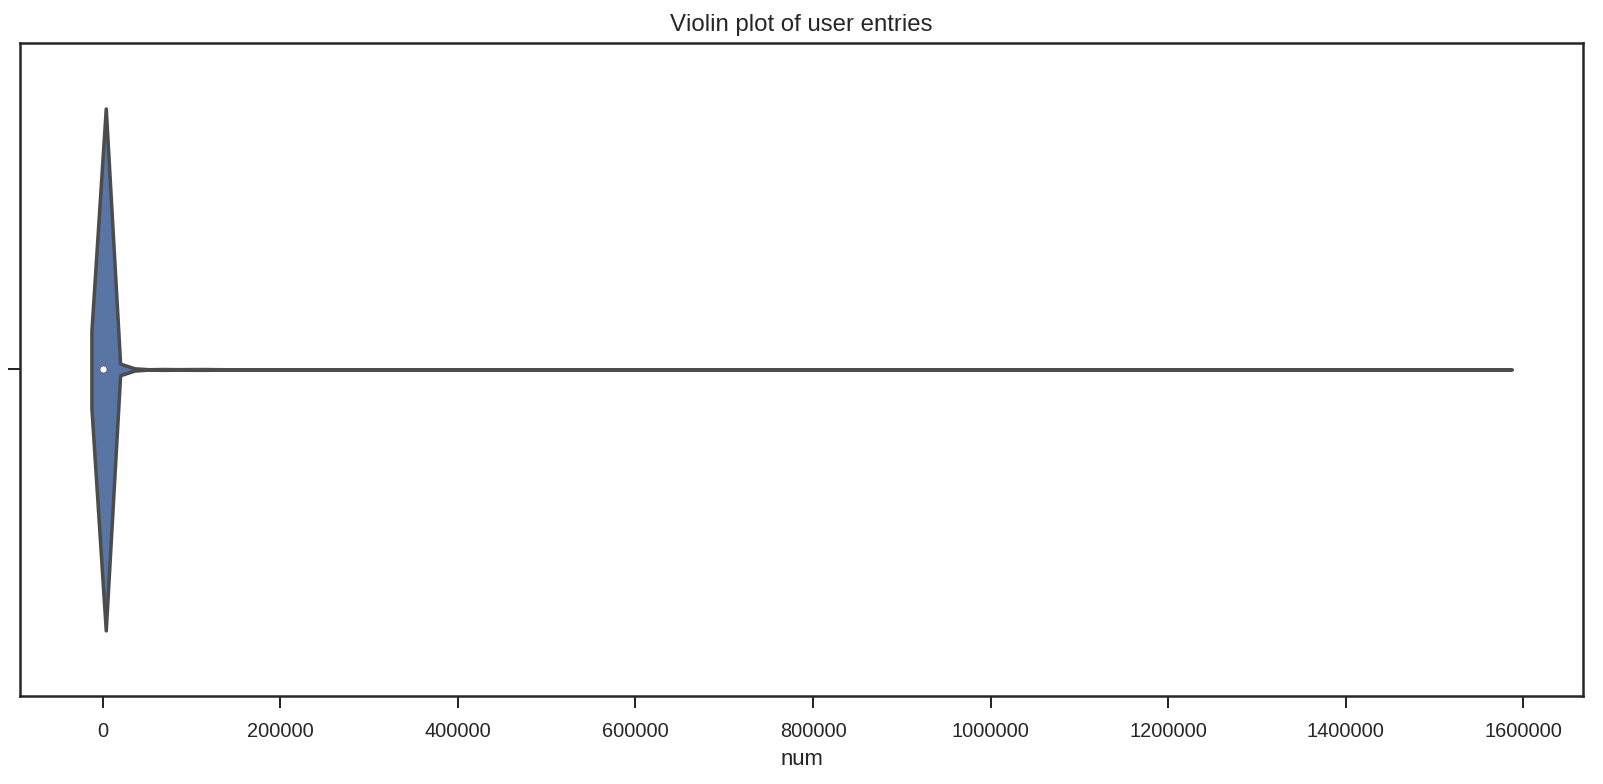

In [106]:
plt.figure(figsize=(14,6))
sns.violinplot(df['num'])
plt.title('Violin plot of user entries');

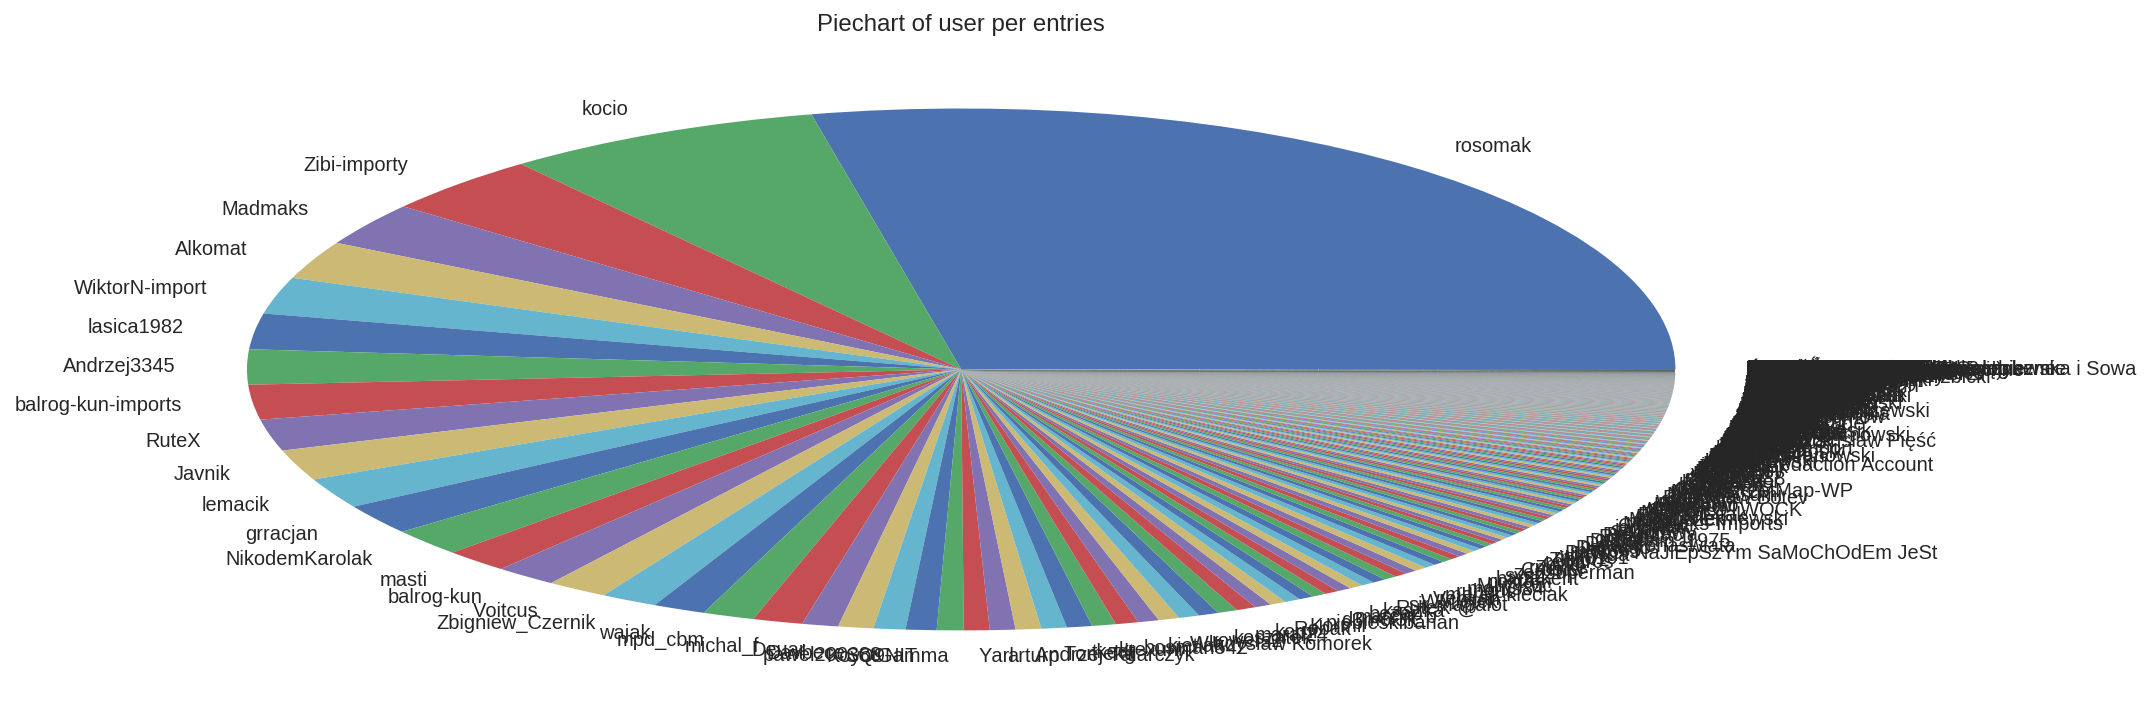

In [107]:
plt.figure(figsize=(16,6))
result.pie()
plt.title('Piechart of user per entries');

The above plots make it very clear how much of the map is actually created by just a few users

### Top 10 appearing amenities in nodes

In [27]:
SELECT value, COUNT(*) as num
FROM nodes_tags
WHERE key='amenity'
GROUP BY value
ORDER BY num DESC
LIMIT 10;

value                           num       
------------------------------  ----------
bench                           1958      
waste_basket                    1472      
restaurant                      1319      
atm                             1015      
pharmacy                        807       
bank                            678       
fast_food                       669       
bicycle_parking                 603       
cafe                            518       
parking                         400       


### Top 10 appearing amenities in ways

In [28]:
SELECT value, COUNT(*) as num
FROM ways_tags
WHERE key='amenity'
GROUP BY value
ORDER BY num DESC
LIMIT 10;

value                           num       
------------------------------  ----------
parking                         8145      
parking_space                   1008      
school                          673       
place_of_worship                413       
kindergarten                    355       
shelter                         277       
fuel                            199       
public_building                 191       
restaurant                      143       
car_wash                        122       


### Top 10 popular cuisines
Including both ways and nodes and filtered for any values that could be duplicate by looking at ways_nodes table.

In [17]:
%%sql
SELECT a.value, COUNT(*) as num
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as a
      JOIN
     (SELECT DISTINCT(id) FROM nodes_tags WHERE nodes_tags.value='restaurant'
      AND nodes_tags.id NOT IN
                       (SELECT ways_nodes.node_id FROM ways_nodes
                        JOIN
                       (SELECT DISTINCT(id) FROM ways_tags WHERE ways_tags.value='restaurant') as b
                       ON ways_nodes.id = b.id)
      UNION ALL
      SELECT DISTINCT(id) FROM ways_tags WHERE ways_tags.value='restaurant') as c
      ON a.id=c.id
WHERE a.key='cuisine'
GROUP BY a.value
ORDER BY num DESC
LIMIT 10;

value,num
pizza,175
regional,119
italian,107
sushi,72
asian,56
indian,24
chinese,23
polish,22
international,21
burger,15


Pizza for the win! The results look consistent from the feeling one get's by living in the region.

### Top 10 Coffeeshop Chains

After having cleaned the values, we can plot them using Pandas again and SQLAlchemy this time

In [2]:
from sqlalchemy import create_engine  
localhost = 'sqlite:///warsaw_poland.db'  
engine = create_engine(localhost)

In [18]:
df = pd.read_sql("""SELECT a.value, COUNT(*) as num
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as a
      JOIN
     (SELECT DISTINCT(id) FROM nodes_tags WHERE nodes_tags.value='cafe'
      AND nodes_tags.id NOT IN
                       (SELECT ways_nodes.node_id FROM ways_nodes
                        JOIN
                       (SELECT DISTINCT(id) FROM ways_tags WHERE ways_tags.value='cafe') as b
                       ON ways_nodes.id = b.id)
      UNION ALL
      SELECT DISTINCT(id) FROM ways_tags WHERE ways_tags.value='cafe') as c
      ON a.id=c.id
WHERE a.key='name'
GROUP BY a.value
ORDER BY num DESC""", engine)


In [19]:
df.head()


,value,num
0,Costa Coffee,41
1,Green Caffè Nero,28
2,Starbucks,11
3,A. Blikle,6
4,Grycan,5


In [4]:
len(df)

403

We have 403 different coffee names

In [20]:
# Filter only for chains
df=df.loc[df.num>2]

In [6]:
len(df)

8

Only 8 appear to have 3 or more locations

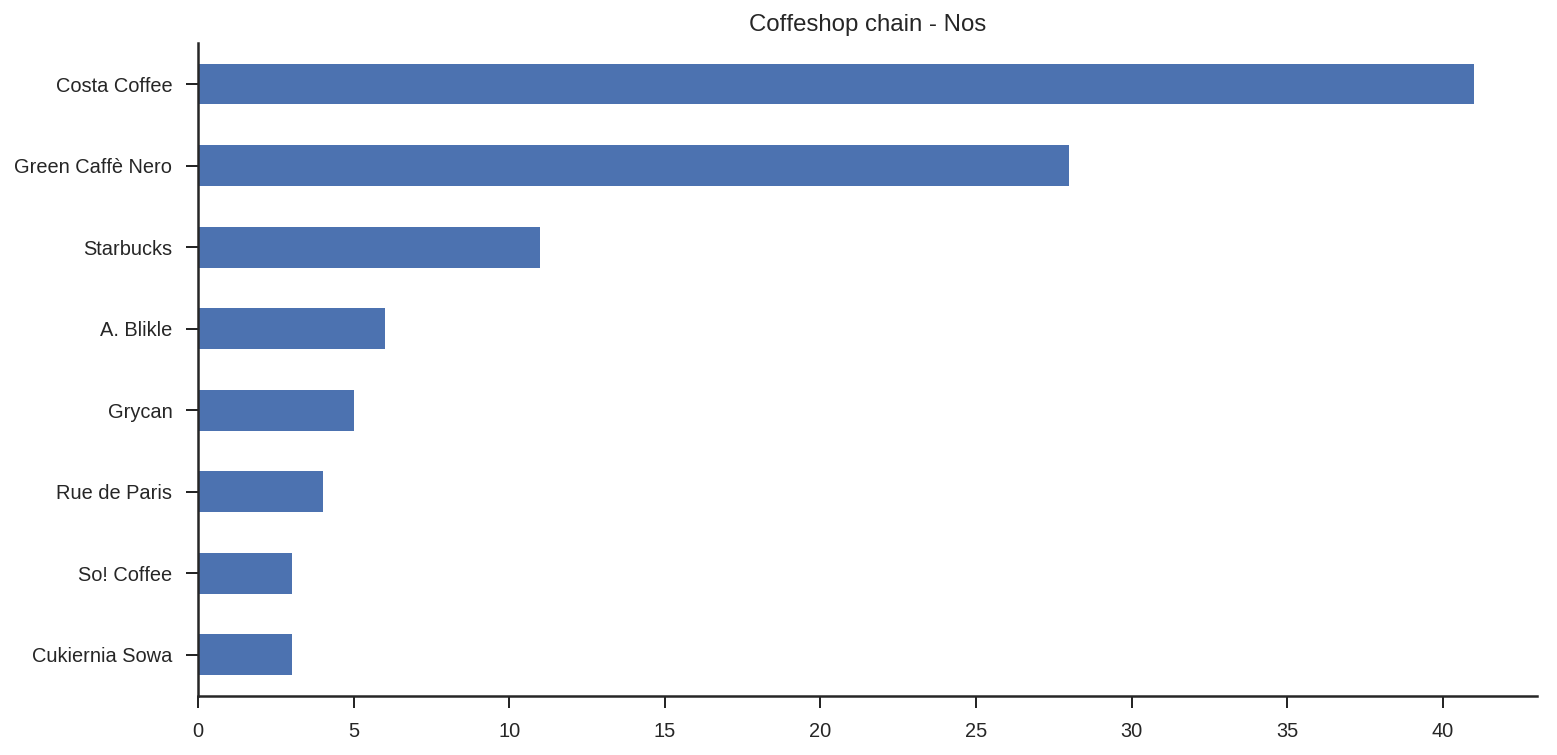

In [27]:
df.groupby(['value']).sum().sort_values(['num']).plot(kind='barh', legend=False, figsize=(12,6))
plt.ylabel('')
plt.xlabel('')
plt.title('Coffeshop chain - Nos')
sns.despine();

A.Blikle and Grykan are the local brands and `Costa Coffee` and `Green Caffè Nero` are indeed dominating the cafe scene.

### Which is the address of the Cafe Lukullus?

Looking at the full Cafe results, the Name Lukullus stood out and I wanted to find out, it's adress and contact details.

In [141]:
SELECT key, value, a.id 
FROM
(SELECT * 
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='Lukullus') as i
    ON nodes_tags.id=i.id) as a
WHERE type='addr' 
OR key='phone'
OR key='website'

key                   value                                                   a.id      
--------------------  ------------------------------------------------------  ----------
website               http://cukiernialukullus.pl/gdzie-jestesmy/saska-kepa/  461166217 
city                  Warszawa                                                461166217 
street                Walecznych                                              461166217 
housenumber           29                                                      461166217 


That is not that far away!

Although, by taking a look at the site I found six additional locations that are not included in this map.

### Top 10 Fast Food Chains

In [137]:
SELECT a.value, COUNT(*) as num
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as a
      JOIN
     (SELECT DISTINCT(id) FROM nodes_tags WHERE nodes_tags.value='fast_food'
      AND nodes_tags.id NOT IN
                       (SELECT ways_nodes.node_id FROM ways_nodes
                        JOIN
                       (SELECT DISTINCT(id) FROM ways_tags WHERE ways_tags.value='fast_food') as b
                       ON ways_nodes.id = b.id)
      UNION ALL
      SELECT DISTINCT(id) FROM ways_tags WHERE ways_tags.value='fast_food') as c
      ON a.id=c.id
WHERE a.key='name'
GROUP BY a.value
ORDER BY num DESC
LIMIT 10;

value                 num       
--------------------  ----------
McDonald's            54        
KFC                   31        
Kebab                 22        
Subway                15        
Pizza Hut             9         
Bobby Burger          8         
Burger King           7         
Kebab King            7         
Telepizza             7         
Domino's Pizza        6         


## Additional Ideas
---

### Top religions (by `religion` value tagged at `place of worship`)

Exploring the `religion` value separately for `ways` and `tags` nodes gives the following results:

__For `nodes`:__

In [8]:
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='place_of_worship') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='religion'
GROUP BY nodes_tags.value
ORDER BY num DESC;

value                           num       
------------------------------  ----------
christian                       106       
multifaith                      2         
muslim                          1         


__And for `ways`:__

In [9]:
SELECT ways_tags.value, COUNT(*) as num
FROM ways_tags 
    JOIN (SELECT DISTINCT(id) FROM ways_tags WHERE value='place_of_worship') i
    ON ways_tags.id=i.id
WHERE ways_tags.key='religion'
GROUP BY ways_tags.value
ORDER BY num DESC;

value                           num       
------------------------------  ----------
christian                       405       
buddhist                        2         
jewish                          2         
muslim                          1         


We observe that there are religions in `nodes` that do not appear in `ways` which makes sense since  [`node` elements are points in space, and `way` elements are regions](http://wiki.openstreetmap.org/wiki/Elements).

The same also holds the other way around in the above aggregation for the `buddhist` religion which suggests that there are `nodes` included in the `ways` tags that don't correspond to the node id's.

We can find out the total unique values , including both ways and nodes and filtered for any values that could be duplicate by looking at ways_nodes table with the following query:

In [29]:
SELECT a.value, COUNT(*) as num
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as a
      JOIN
     (SELECT DISTINCT(id) FROM nodes_tags WHERE nodes_tags.value='place_of_worship'
      AND nodes_tags.id NOT IN
                       (SELECT ways_nodes.node_id FROM ways_nodes
                        JOIN
                       (SELECT DISTINCT(id) FROM ways_tags WHERE ways_tags.value='place_of_worship') as b
                       ON ways_nodes.id = b.id)
      UNION ALL
      SELECT DISTINCT(id) FROM ways_tags WHERE ways_tags.value='place_of_worship') as c
      ON a.id=c.id
WHERE a.key='religion'
GROUP BY a.value
ORDER BY num DESC
LIMIT 10;

value                           num       
------------------------------  ----------
christian                       511       
buddhist                        2         
jewish                          2         
multifaith                      2         
muslim                          2         


It is interesting to observe that there are no overlapping entries in node_tags and ways_tags!

This [discussion](https://discussions.udacity.com/t/Inconsistent-node-and-way-values-for-key-religion-and-value-place-of-worship/250453/3) implies that this may be a common phenomenon.

Subsequently, I used for this report the full SQL query above to aggregate data making sure to get all the possible values of the map.

This may suggest that `way` and `node` tags are entered independently and could include the possibility of duplicate `node` entries
that have been entered with different `node` `ids`.

A way to make sure that there are no duplicate node entries could be a automatic double checking, (using a nosql query possibly)  at the time of a `node` entry at a `way`, of the location of the node (with some tolerance to account for small differences on map placement) and prompting the user  to use the already existing one.  
This could also work the other way around when a `node` is entered and a similar `node` in the vicinity already exists in a `way` 

Further exploration of other keys, other maps as well as the map editing process can shed more light on these assumptions.

## References
---
https://discussions.udacity.com/t/Inconsistent-node-and-way-values-for-key-religion-and-value-place-of-worship/250453/3   
https://sqlite.org/cli.html   
https://github.com/brownan/sqlite3-kernel   
https://www.w3schools.com/sql/sql_join.asp
https://github.com/cs109/2015/blob/master/Lectures/Lecture4/PandasAndSQL.ipynb
https://gist.github.com/carlward/54ec1c91b62a5f911c42#file-sample_project-md